In [38]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community
#!pip install isbnlib
from isbnlib import meta
from isbnlib.registry import bibformatters
from numba import jit

from operator import itemgetter
#!pip install python-louvain
#!pip install community
from community import community_louvain
import matplotlib.cm as cm

In [2]:
#df = pd.read_csv('rec-amz-Books.edges', header=None, names=['ID_reviewer', 'ISBN', 'Stars', 'Date'])

In [3]:
def subgraphByListOfValues(values: pd.Series, column: str, df: pd.DataFrame) -> pd.DataFrame:
    return df[np.isin(df[column], values)]

def randomSubgraph(n:int, column: str, df: pd.DataFrame, weighed: bool = True, seed: int = 3) -> pd.DataFrame:
    np.random.seed(seed)
    values, counts = np.unique(df[column], return_counts=True)
    return subgraphByListOfValues(np.random.choice(values, n, replace=False, p=(counts / sum(counts)) if weighed else None), column, df)

In [18]:
#subdf = randomSubgraph(500, 'ISBN', df, seed=3) # 500 za 3 min a 6 sekund

In [19]:
B = nx.Graph()
B.add_nodes_from(subdf['ID_reviewer'], bipartite=0)
B.add_nodes_from(subdf['ISBN'],bipartite=1)
B.add_weighted_edges_from(subdf.iloc[:,:3].apply(tuple, axis=1))

In [20]:
# matica knih, bezvahova

authors = subdf['ID_reviewer'].unique()
books = subdf['ISBN'].unique()

A=bipartite.biadjacency_matrix(B, books, weight=None).todense()

# samotny algoritmus
@jit(nopython=True)
def proj(B_graph):
    n1 = B_graph.shape[0]
    #print(n1)
    n2 = B_graph.shape[1]
    A_pr = np.zeros((n1,n1))
    for i in range(n1):
        for j in range(i+1, n1):
            for k in range(n2):
                if B_graph[i][k] == 1 and B_graph[j][k] == 1:
                    A_pr[i][j] = 1
                    A_pr[j][i] = 1
                    break
                else:
                    A_pr[j][i] = 0
    return A_pr
A_p = proj(A)
#A_p

G_knihy = nx.from_numpy_array(A_p)
node_map = dict(zip(list(G_knihy),books))
G_knihy = nx.relabel_nodes(G_knihy, dict(zip(list(G_knihy),books)))

# 500 knih sa 1 minutu

In [36]:
bipartite.is_bipartite(B)

True

In [22]:
#kompletnost grafu, hustota
print("hustota knih:", nx.density(G_knihy))

hustota knih: 0.05745891783567134


In [ ]:
#najkratsia vzdialenost medzi 2ma vrcholmi
#path1 = nx.shortest_path(G_knihy, source="0002247399", target="0002007770")
print("Shortest path:", nx.shortest_path(G_knihy, source="", target=""))

In [30]:
#je graf jeden komponent?
print("je bipartitný graf, pôvodný graf, 1 komponent? :",  nx.is_connected(B))
print("------------")
print("je graf kníh 1 komponent? : ",  nx.is_connected(G_knihy))

je bipartitný graf, pôvodný graf, 1 komponent? : False
------------
je graf kníh 1 komponent? :  False


In [31]:
komponenty_knih = nx.connected_components(G_knihy)
najvacsi_kom_knih = max(komponenty_knih, key=len)
G_knihy_najvacsi_kom = G_knihy.subgraph(najvacsi_kom_knih)
print("diameter najvacsieho komponentu knih:", nx.diameter(G_knihy_najvacsi_kom))

diameter najvacsieho komponentu knih: 5


In [32]:
print("zhlukovy koeficient knih:", nx.transitivity(G_knihy))

zhlukovy koeficient knih: 0.4351088330533862


In [39]:
print('modularita:', community.modularity(G_knihy, nx.connected_components(G_knihy)))

modularita: 0.00027897893166069985


Na prednáške sme brali tieto typy centralít: eigenvector, katz, pagerank, closeness, betweenness
Networkx ponúka okrem tých vyššie ešte aj: degree, hubs and authorities, prestige
Zatiaľ som spravila: degree, betweenness, eigenvectors

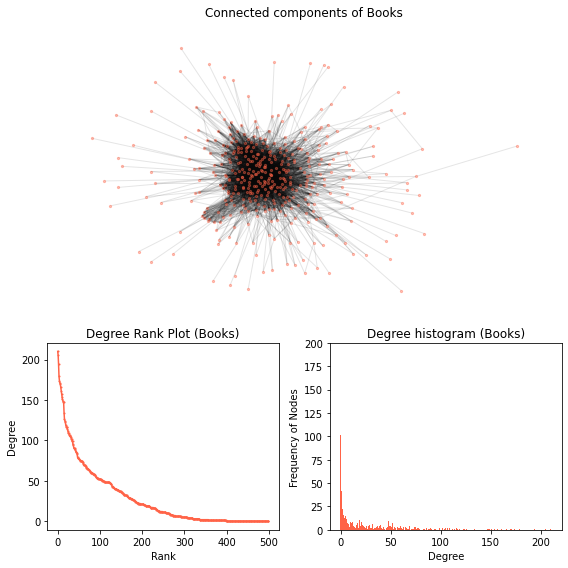

In [26]:
#stupne vrcholov
degree_sequence = sorted([d for n, d in G_knihy.degree()], reverse=True)

Gcc = G_knihy.subgraph(sorted(nx.connected_components(G_knihy), key=len, reverse=True)[0])

fig = plt.figure("Degree of the books", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Books")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, marker="o", markersize=1, color='tomato')
ax1.set_title("Degree Rank Plot (Books)")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color='tomato')
ax2.set_title("Degree histogram (Books)")
ax2.set_xlabel("Degree")
ax2.set_ylim([0, 200])
ax2.set_ylabel("Frequency of Nodes")

fig.tight_layout()
plt.show()

In [33]:
def from_ISBN_to_title(column):
    new_col = list()
    SERVICE = "openl"
    bibtex = bibformatters["json"]
    for value in column:
        isbn = str(value)
        book_data = json.loads(bibtex(meta(isbn, SERVICE)))
        #print(book_data["title"])
        new_col.append(book_data["title"])
    return new_col

In [34]:
#degree centrality
stupne_knih = nx.degree_centrality(G_knihy)
stupne_knih = sorted(stupne_knih.items(), key=lambda x:x[1], reverse=True)[:10]
stupne_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Degree centrality'])
stupne_knih_df['Book ISBN'] = [t[0] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = [t[1] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = stupne_knih_df['Degree centrality'].apply(lambda x: round(x, 3))
stupne_knih_df['Book title'] = from_ISBN_to_title(stupne_knih_df['Book ISBN'])
stupne_knih_df

,Book ISBN,Book title,Degree centrality
0,030758836X,Gone Girl,0.421
1,0143170090,The Girl With the Dragon Tattoo,0.411
2,0141039280,The help,0.389
3,0345803485,Fifty Shades of Grey,0.359
4,0849922070,Heaven is For Real Movie Edition,0.349
5,0316036919,Host,0.343
6,030728090X,Twilight [audiobook],0.341
7,0718178122,The Rosie Project,0.333
8,0385340990,The Guernsey Literary and Potato Peel Pie Society,0.323
9,038536315X,Sycamore row,0.315


In [35]:
#eigenvector centrality
eigenvector_knihy = nx.eigenvector_centrality(G_knihy)
sorted_eigenvector_knihy = sorted(eigenvector_knihy.items(), key=itemgetter(1), reverse=True)[:10]
eigenvector_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Eigenvector centrality'])
eigenvector_knih_df['Book ISBN'] = [t[0] for t in sorted_eigenvector_knihy]
eigenvector_knih_df['Eigenvector centrality'] = [t[1] for t in stupne_knih]
eigenvector_knih_df['Eigenvector centrality'] = eigenvector_knih_df['Eigenvector centrality'].apply(lambda x: round(x, 3))
eigenvector_knih_df['Book title'] = from_ISBN_to_title(eigenvector_knih_df['Book ISBN'])

eigenvector_knih_df

,Book ISBN,Book title,Eigenvector centrality
0,030758836X,Gone Girl,0.421
1,0143170090,The Girl With the Dragon Tattoo,0.411
2,0316036919,Host,0.389
3,0141039280,The help,0.359
4,0345803485,Fifty Shades of Grey,0.349
5,0718178122,The Rosie Project,0.343
6,030728090X,Twilight [audiobook],0.341
7,0849922070,Heaven is For Real Movie Edition,0.333
8,0399159347,The Husband's Secret,0.323
9,0345803493,Fifty shades darker,0.315


In [36]:
#betweenness centrality
betweenness_knihy = nx.betweenness_centrality(G_knihy)
sorted_betweenness_knihy = sorted(betweenness_knihy.items(), key=itemgetter(1), reverse=True)[:10]
betweenness_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Betweenness centrality'])
betweenness_knih_df['Book ISBN'] = [t[0] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = [t[1] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = betweenness_knih_df['Betweenness centrality'].apply(lambda x: round(x, 3))
betweenness_knih_df['Book title'] = from_ISBN_to_title(betweenness_knih_df['Book ISBN'])
betweenness_knih_df

,Book ISBN,Book title,Betweenness centrality
0,0143170090,The Girl With the Dragon Tattoo,0.043
1,0141039280,The help,0.036
2,030758836X,Gone Girl,0.035
3,0849922070,Heaven is For Real Movie Edition,0.033
4,0345803485,Fifty Shades of Grey,0.032
5,0385340990,The Guernsey Literary and Potato Peel Pie Society,0.021
6,0316001821,The Lovely Bones - Deluxe Edition,0.021
7,030728090X,Twilight [audiobook],0.020
8,038536315X,Sycamore row,0.019
9,0805096663,Killing Kennedy - The end of Camelot,0.018


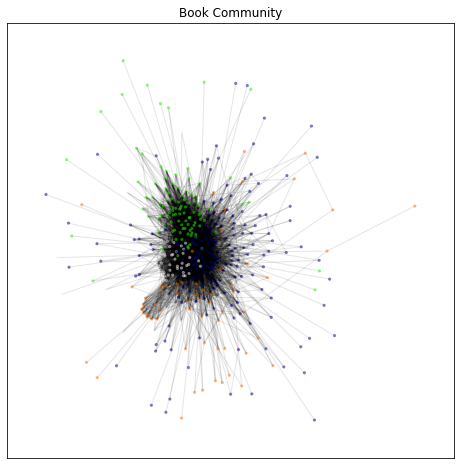

In [37]:
#vyberieme najvacsi komponent
Gcc = G_knihy.subgraph(sorted(nx.connected_components(G_knihy), key=len, reverse=True)[0])

#zadelime do komunit podla Louvian method
partition_knihy = community_louvain.best_partition(Gcc)

#zafarbime podla komunit
cmap = cm.get_cmap('gist_ncar', max(partition_knihy.values()) + 1)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_knihy.keys(), node_size=5, alpha=0.4, cmap=cmap, node_color=list(partition_knihy.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Book Community")
plt.show()